# ISC

In [13]:
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm
from util import plot
import matplotlib.pyplot as plt
from himalaya.scoring import correlation_score
from scipy.stats import pearsonr

from util.atlas import Atlas
from util.path import Path

from constants import SUBS

In [2]:
%cd ..

/scratch/gpfs/zzada/narrative-gradients


In [16]:
narrative = 'forgot'
narrative = 'black'

atlas = Atlas.schaefer(parcels=1000, networks=17, kong=True)

# ISC by leave-one-out

In [10]:
scores = []
for sub_id in tqdm(SUBS[narrative]):

    subpath = Path(
        root="data/derivatives/clean",
        datatype="func",
        sub=f"{sub_id:03d}",
        task=narrative,
        space="fsaverage6",
        ext=".h5",
    )

    grouppath = Path(
        root="data/derivatives/leaveout",
        datatype="func",
        sub=f"{sub_id:03d}",
        task=narrative,
        space="fsaverage6",
        ext=".h5",
    )

    with h5py.File(subpath, "r") as f:
        boldS = f["bold"][...]

    with h5py.File(grouppath, "r") as f:
        boldO = f["bold"][...]

    scores.append(correlation_score(boldS, boldO))

100%|██████████| 46/46 [00:55<00:00,  1.21s/it]


In [11]:
scores = np.stack(scores)
scores.shape

(46, 81924)

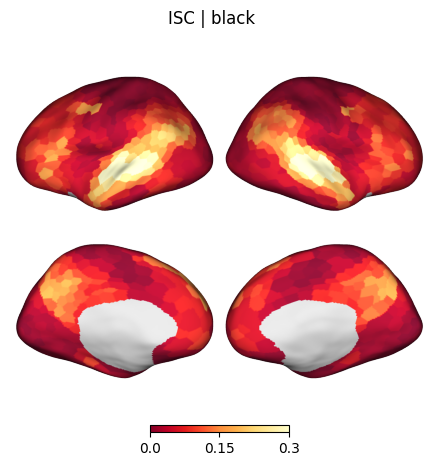

In [17]:
values = scores.mean(0)
values = atlas.parc_to_vox(atlas.vox_to_parc(values))

fig = plot.surface_plot(values, vmin=0, vmax=0.3, cmap='YlOrRd_r', title=f'ISC | {narrative}')
fig.show()

## load scores

In [39]:
# get scores
df = pd.read_csv('data/participants.tsv', sep='\t')
df['task'] = df.task.str.split(',')
df['comprehension'] = df.comprehension.str.split(',')
df['participant_id'] = df.participant_id.apply(lambda x: int(x.split('-')[1]))
df.head()

,participant_id,age,sex,task,condition,comprehension
0,1,"22,23","F,F","[pieman, tunnel]","n/a,n/a","[n/a, n/a]"
1,2,20,M,[pieman],NaN,NaN
2,3,NaN,F,[pieman],NaN,NaN
3,4,"24,24","M,M","[pieman, tunnel]","n/a,n/a","[n/a, n/a]"
4,5,"n/a,n/a","M,M","[pieman, tunnel]","n/a,n/a","[n/a, n/a]"


In [47]:
df2 = df.explode(['task', 'comprehension'])
df2['comprehension'] = df2.comprehension.str.replace('n/a', 'nan')
df2['comprehension'] = df2.comprehension.apply(float)
df3 = df2[df2.task == 'black']
df3.set_index('participant_id', inplace=True)
df3.head()

,age,sex,task,condition,comprehension
participant_id,,,,,
127,"31,30,30,32,32,32,32","F,F,F,F,F,F,F",black,"synonyms,movie-physical-social,movie-physical-...",0.76
265,"19,20,20,20,20","F,F,F,F,F",black,"n/a,n/a,n/a,n/a,n/a",0.76
267,"26,27,27,27,27","F,F,F,F,F",black,"n/a,n/a,n/a,n/a,n/a",0.88
272,"19,19,19,19","F,F,F,F",black,"n/a,n/a,n/a,n/a",0.64
273,"20,20,20,20","M,M,M,M",black,"n/a,n/a,n/a,n/a",0.96


In [51]:
comp_scores = df3.loc[SUBS[narrative]]['comprehension'].to_numpy()
len(comp_scores)

46

In [57]:
pearsonr(comp_scores, np.median(scores, 1))

PearsonRResult(statistic=0.5586859802552582, pvalue=5.4560995921119695e-05)